In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, auc
)
from sklearn.model_selection import cross_val_score
import joblib
import pickle

# Set style for plots
plt.style.use('dark_background')
%matplotlib inline

In [2]:
# Load the dataset
data = pd.read_csv('advertising.csv')

# Drop unnecessary columns
data.drop('City', axis=1, inplace=True)

# Convert timestamp to datetime and extract features
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Month'] = data['Timestamp'].dt.month

# Drop the original timestamp column
data.drop('Timestamp', axis=1, inplace=True)

# Display dataset info
print("Dataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())
print("\nFirst 5 rows:")
data.head()

Dataset Shape: (1000, 11)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   Male                      1000 non-null   int64  
 6   Country                   1000 non-null   object 
 7   Clicked on Ad             1000 non-null   int64  
 8   Hour                      1000 non-null   int32  
 9   DayOfWeek                 1000 non-null   int32  
 10  Month                     1000 non-null   int32  
dtypes: float64(3), int32(3), int64(3), object(2)
memory usage: 74.3+ KB
None

First 5 rows:


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,Male,Country,Clicked on Ad,Hour,DayOfWeek,Month
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,0,Tunisia,0,0,6,3
1,80.23,31,68441.85,193.77,Monitored national standardization,1,Nauru,0,1,0,4
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,0,San Marino,0,20,6,3
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,1,Italy,0,2,6,1
4,68.37,35,73889.99,225.58,Robust logistical utilization,0,Iceland,0,3,4,6


Missing values:
 Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
Male                        0
Country                     0
Clicked on Ad               0
Hour                        0
DayOfWeek                   0
Month                       0
dtype: int64

Class distribution (Clicked on Ad):
Clicked on Ad
0    500
1    500
Name: count, dtype: int64

Class percentage:
Clicked on Ad
0    0.5
1    0.5
Name: proportion, dtype: float64


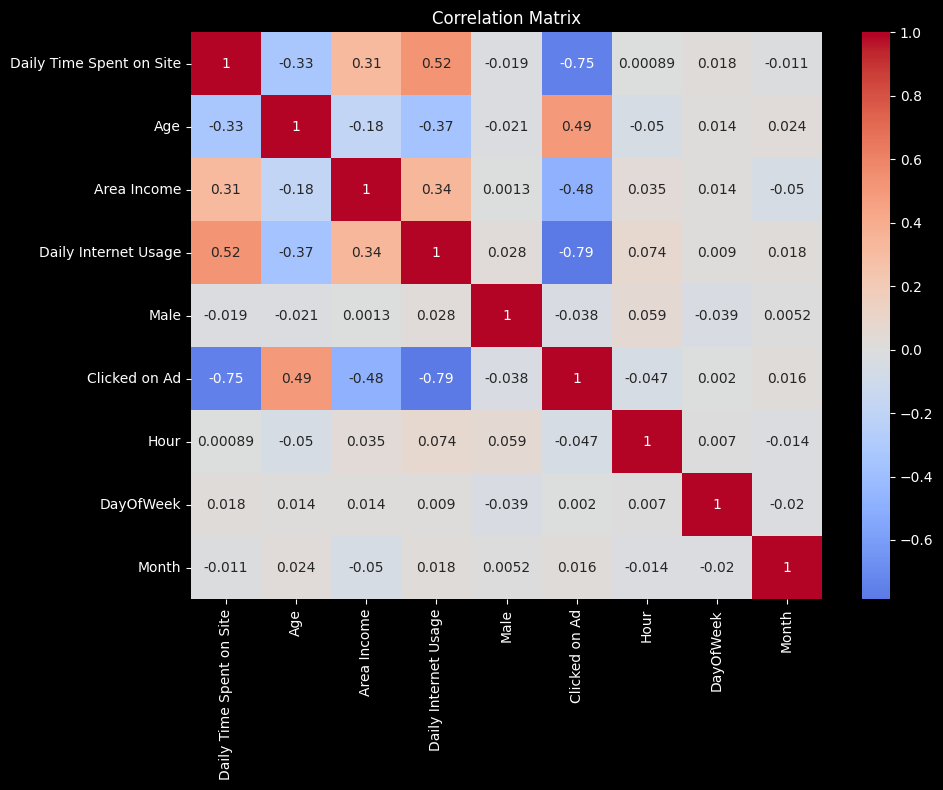

In [3]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Check class distribution
print("\nClass distribution (Clicked on Ad):")
print(data['Clicked on Ad'].value_counts())
print("\nClass percentage:")
print(data['Clicked on Ad'].value_counts(normalize=True))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
numeric_cols = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [4]:
# Create a copy of the data for modeling
model_data = data.copy()

# Define features and target
X = model_data.drop('Clicked on Ad', axis=1)
y = model_data['Clicked on Ad']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['Ad Topic Line', 'Country']
Numerical columns: ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Male']


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")

Training set shape: (800, 10)
Testing set shape: (200, 10)
Training target distribution:
Clicked on Ad
1    0.5
0    0.5
Name: proportion, dtype: float64
Testing target distribution:
Clicked on Ad
1    0.5
0    0.5
Name: proportion, dtype: float64


In [6]:
# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the full pipeline with logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Display the pipeline
model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

print("Model training completed!")

Model training completed!


Accuracy: 0.9800
ROC AUC Score: 0.9902

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       100
           1       0.99      0.97      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



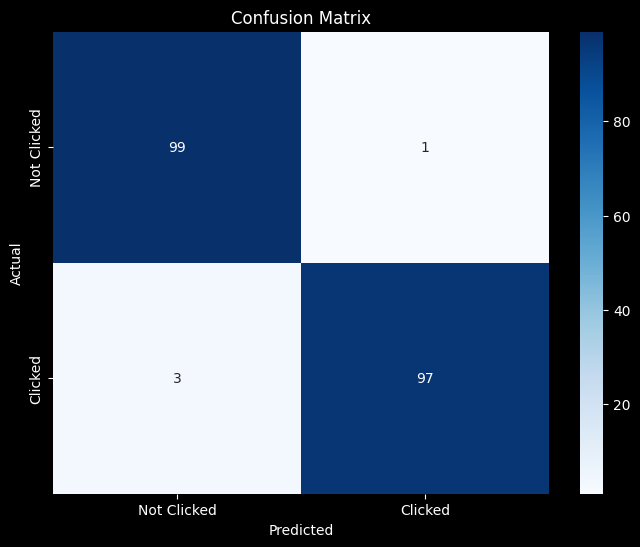

In [8]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Clicked', 'Clicked'], 
            yticklabels=['Not Clicked', 'Clicked'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

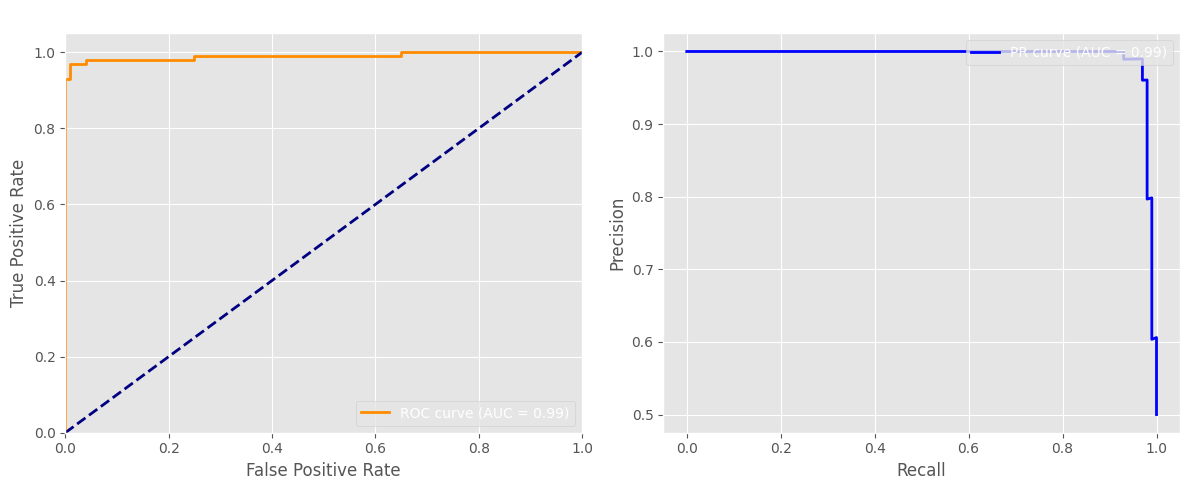

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [17]:
results_table = pd.DataFrame({
    "Metric": ["ROC AUC", "PR AUC"],
    "Value": [roc_auc, pr_auc]
})

display(results_table)

,Metric,Value
0,ROC AUC,0.990200
1,PR AUC,0.993213


In [12]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

print("Cross-Validation ROC AUC Scores:", cv_scores)
print(f"Mean ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation ROC AUC Scores: [0.9992 0.9889 0.9998 0.9853 0.9834]
Mean ROC AUC: 0.9913 (+/- 0.0138)


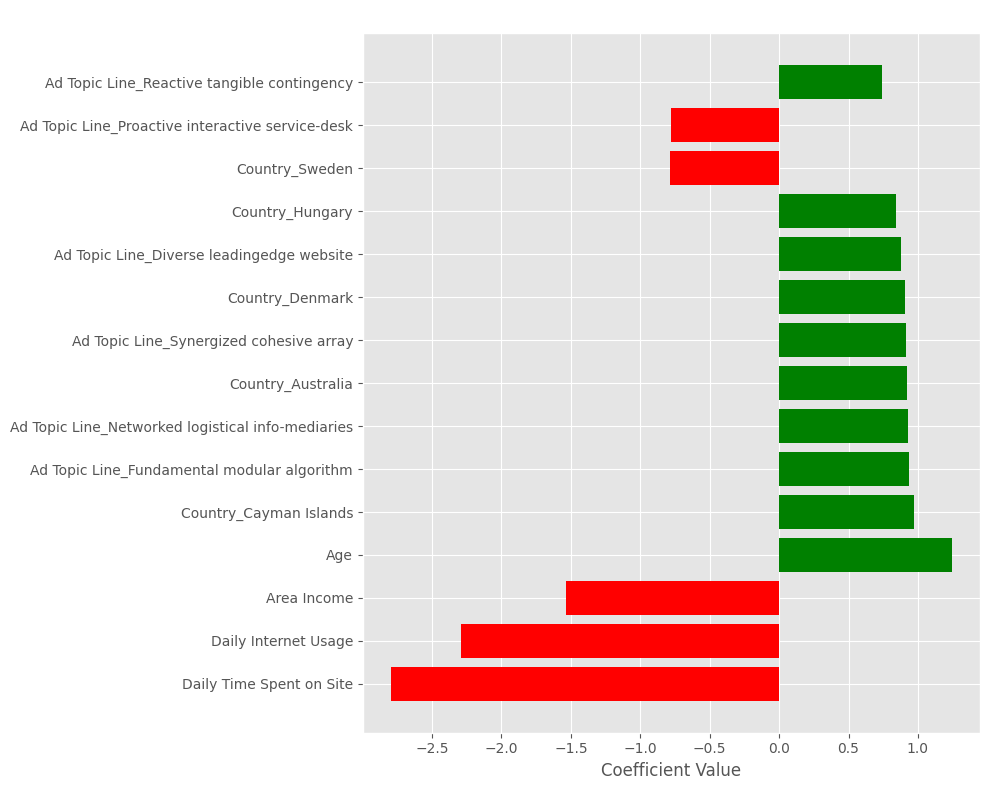

In [13]:
# Get feature names after preprocessing
preprocessor = model.named_steps['preprocessor']
feature_names = numerical_cols.copy()

# Add one-hot encoded categorical feature names
for col in categorical_cols:
    categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[categorical_cols.index(col)]
    feature_names.extend([f"{col}_{cat}" for cat in categories])

# Get coefficients from the logistic regression model
classifier = model.named_steps['classifier']
coefficients = classifier.coef_[0]

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
}).sort_values('Importance', key=abs, ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
colors = ['red' if x < 0 else 'green' for x in top_features['Importance']]
plt.barh(top_features['Feature'], top_features['Importance'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()

### Saving the model

In [14]:
# Save the entire pipeline (including preprocessing)
joblib.dump(model, 'ad_click_model.pkl')

# Also save the column names for reference
model_metadata = {
    'categorical_cols': categorical_cols,
    'numerical_cols': numerical_cols,
    'feature_names': feature_names
}

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)

print("Model and metadata saved successfully!")

Model and metadata saved successfully!


In [15]:
# Create a sample input for testing
sample_data = X_test.iloc[:1].copy()
print("Sample input:")
print(sample_data)

# Make prediction
prediction = model.predict(sample_data)
prediction_proba = model.predict_proba(sample_data)

print(f"\nPrediction: {'Click' if prediction[0] == 1 else 'No Click'}")
print(f"Probability of clicking: {prediction_proba[0][1]:.4f}")
print(f"Probability of not clicking: {prediction_proba[0][0]:.4f}")

Sample input:
     Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  \
832                     41.46   42      52177.4                128.98   

                      Ad Topic Line  Male Country  Hour  DayOfWeek  Month  
832  Integrated impactful groupware     1   Malta     8          0      5  

Prediction: Click
Probability of clicking: 0.9999
Probability of not clicking: 0.0001


In [24]:
data[data['Clicked on Ad'] == 0].loc[0]

Daily Time Spent on Site                                 68.95
Age                                                         35
Area Income                                            61833.9
Daily Internet Usage                                    256.09
Ad Topic Line               Cloned 5thgeneration orchestration
Male                                                         0
Country                                                Tunisia
Clicked on Ad                                                0
Hour                                                         0
DayOfWeek                                                    6
Month                                                        3
Name: 0, dtype: object